## Context of the paper


Optimal transport (OT) is a significant method in machine learning for transferring data between different probability measures, offering both theoretical insights and practical benefits. The application of OT is illustrated through various tasks such as domain adaptation, training generative models, and aligning datasets in natural sciences.

A particular focus is given to the challenges of applying OT in high-dimensional settings (denoted as "High-dimensional Transport") which is way more challenging than applying OT in low-dimensional where the definition of a cost function is often straightforward and intuitive. The traditional use of the Euclidean distance metric in the high-dimensional settings often becomes less effective due to the curse of dimensionality, leading to a loss in discriminative power.

To overcome these issues, the paper (https://proceedings.mlr.press/v202/cuturi23a.html) discusses the use of dimensionality reduction techniques and advanced feature transformations, like PCA, VAEs or Sliced-Wasserstein distances, to make the transport maps more interpretable and effective. These methods include projecting data onto lower-dimensional subspaces using techniques onto hyperplanes, lines, and other structures.

Furthermore, a new approach is presented based on "sparse optimal transport" where the goal is to create sparse mapping between distributions. This new method uses a generalized entropic map with translation invariant costs, which induces sparsity in the displacement vectors.

## Monge Bregman Occam 



In this tutorial, we will conduct a synthetic application, based on the new model that we discuss earlier, to demonstrate that the Monge Bregman Occam estimator is effective for transport problems where only a select few coordinates are altered.

We introduce a generalized entropic map $T_{h,\epsilon}$, inspired on the one presented by Pooladian and Niles-Weed in 2021, for translation invariant costs
$c(x, y) := h(x - y)$ where $h : \mathbb{R}^d \rightarrow \mathbb{R}$ is an elastic type regularizer defined by $h(z) := \frac{1}{2} \|z\|^2 + \tau(z)$ with $\tau : \mathbb{R^d} \rightarrow \mathbb{R}$ a function whose proximal operator is well-defined.
That entropic map $T_{h,\epsilon}$ is defined almost everywhere (a.e.), and we show that it induces displacements $$\Delta(x) := T_{h,\epsilon}(x) - x$$

Our goal is to create sparse mapping between distributions hence we want to have a feature-sparse entropic map $T_{h,\epsilon}$ that induces sparsity in the displacement vector. Thus when we consider high dimensional data, $T_{h,\epsilon}$ considers a small number of features of x so that the displacement vector is sparse.

Based on the results proven in the paper we can see that for our function h of elastic-type, we can write the feature-sparse entropic map $T_{h,\epsilon}$ as: 

$$T_{h,\epsilon}(x) = x - \text{prox}_{\tau} \left( x - \sum_{j=1}^{m} p^j(x) \left(y^j - \nabla \tau (x - y^j) \right) \right)$$
since $ \nabla h^*= \text{prox}_{\tau}$

This result allows OTT-JAX to compute $T_{h,\epsilon}$ for individual data points, thereby facilitating the evaluation of estimation quality through the Normalized Mean Squared Error (NMSE) and Support error metric.


## Synthetic experiments: Constant sparsity-pattern

In this part, we took a distribution $\mu = U[0,1]^d$ defined over a d-dimensional space that we will transform into another distribution $\nu = T^\star_s \sharp \mu$  for $s \leq d$ through a sparse transport map $T^\star_s(x) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d]$ that modifies only the first s coordinates of the input vector. 

The effectiveness of our method in accurately recovering this transport map $T^\star_s$ is evaluated using two metrics:

Normalized Mean Squared Error (MSE): This metric measures the average squared difference between the original and estimated transport maps, normalized by the dimensionality of the data.

Support Error: This metric assesses the method's ability to accurately identify the active (non-zero) components of the map, indicating how well the sparse structure of the map is captured.

These metrics are crucial for demonstrating the precision of our approach in identifying and reconstructing the relevant transformations dictated by $T^\star_s$

In [18]:
import os
from pathlib import Path
import itertools


import numpy as np
from matplotlib import pyplot as plt

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from tqdm import tqdm


We initialize two random number generator keys with JAX: rng with seed 0 and rng2 with seed 1. These keys will be used to manage randomness in our experiments.

In [19]:
rng = jax.random.PRNGKey(0)
rng2 = jax.random.PRNGKey(1)

Now, we define the functions that will be useful for our experiments. 

The entropic mapfunction constructs an entropic map between the two datasets using a specified cost function. It leverages the Sinkhorn algorithm to find an optimal transport map that minimizes the transportation cost subject to entropy regularization. 

The T_star_s  function defines the true transport map by changing the first s coordinates of the vector x. It therefore corresponds to a sparse displacement\

The nmse_func and support error func functions define the two metrics introduced in the paper in order to evaluate our results.

In [20]:
def entropic_map(X1, X2, cost_fn):
    geom = pointcloud.PointCloud(X1, X2, cost_fn=cost_fn)
    solver = jax.jit(sinkhorn.Sinkhorn())
    output = solver(linear_problem.LinearProblem(geom))
    return output.to_dual_potentials().transport

def T_star_s(x, s):
    return jnp.concatenate([jnp.exp(x[:s]), x[s:]])

def nmse_func(T_star, T_h, d):
    return(jnp.mean(jnp.sum((T_star - T_h)**2, axis=1) / d))

def support_error_func(delta, s):
    return(jnp.mean(jnp.sum(delta[:, s+1:]**2, axis=1) / jnp.sum(delta**2, axis=1)))

In [22]:
cost_functions = [costs.ElasticL1(), costs.ElasticSTVS(), costs.ElasticSqKOverlap(k=5), costs.ElasticSqKOverlap(k=7), costs.SqEuclidean()]
cost_names = ['l1', 'STVS', 'ovk_5', 'ovk_7', 'l2']

scale_reg_list = jnp.logspace(jnp.log10(0.01), jnp.log10(20), num=50)
dimensions = [8, 20, 100]
n = 1000
s = 5

Our analysis will consist of studying the performance of our map estimator as a function of the cost function and scale regularization used. To do this, we start by defining a list of 5 cost functions for which we'll vary the scale regularization between 0 and 20, in order to obtain a complete analysis. 

In [23]:
elastic_cost = [costs.ElasticL1(scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
elastic_stvs = [costs.ElasticSTVS(scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
elastic_sqk5 = [costs.ElasticSqKOverlap(k=5, scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
elastic_sqk7 = [costs.ElasticSqKOverlap(k=7, scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
l2_cost = [costs.SqEuclidean() for _ in range(50)]

cost_list = list(itertools.chain(elastic_cost, elastic_stvs, elastic_sqk5, elastic_sqk7, l2_cost))
print(len(cost_list))


250


A transport map is calculated for each combination of cost and scale regularization functions. The ability of these models to approach the theoretical mapping is then measured using the metrics introduced earlier. The scores are stored in a dictionary for future analysis.

In [24]:
def results(cost_func) :
    cost_results = {}
    for dim in dimensions :
        print('cost: ', cost_func[0], 'dimension:', dim) 
        cost_results[f'dim_{dim}'] = {}
        x = jax.random.uniform(rng, (n, dim))
        T_star = jax.vmap(T_star_s, in_axes=(0, None))(x, s)
        
        x_tilde = jax.random.uniform(rng2, (n, dim))
        y = jax.vmap(T_star_s, in_axes=(0, None))(x_tilde, s)

        for index in tqdm(range(len(cost_func))):
            cost_results[f'dim_{dim}'][str(scale_reg_list[index])] = {}

            T_h = entropic_map(x,y,cost_func[index])(x)
            delta = T_h - x

            nmse = nmse_func(T_star, T_h, dim)
            support_error = support_error_func(delta, s)

            cost_results[f'dim_{dim}'][str(scale_reg_list[index])]['NMSE'] = nmse
            cost_results[f'dim_{dim}'][str(scale_reg_list[index])]['support_error'] = support_error
    return(cost_results)

results_dict = {}
results_dict['l1'] = results(elastic_cost)
results_dict['stvs'] = results(elastic_stvs)
results_dict['sqk5'] = results(elastic_sqk5)
results_dict['sqk7'] = results(elastic_sqk7)
results_dict['l2'] = results(l2_cost)

cost:  <ott.geometry.costs.ElasticL1 object at 0x336ae8550> dimension: 8


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


cost:  <ott.geometry.costs.ElasticL1 object at 0x336ae8550> dimension: 20


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


cost:  <ott.geometry.costs.ElasticL1 object at 0x336ae8550> dimension: 100


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x336ae94d0> dimension: 8


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x336ae94d0> dimension: 20


100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x336ae94d0> dimension: 100


100%|██████████| 50/50 [02:32<00:00,  3.04s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336acab50> dimension: 8


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336acab50> dimension: 20


100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336acab50> dimension: 100


100%|██████████| 50/50 [27:35<00:00, 33.12s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336aef090> dimension: 8


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336aef090> dimension: 20


100%|██████████| 50/50 [02:32<00:00,  3.05s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x336aef090> dimension: 100


100%|██████████| 50/50 [25:36<00:00, 30.72s/it]


cost:  <ott.geometry.costs.SqEuclidean object at 0x336adcdd0> dimension: 8


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x336adcdd0> dimension: 20


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x336adcdd0> dimension: 100


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


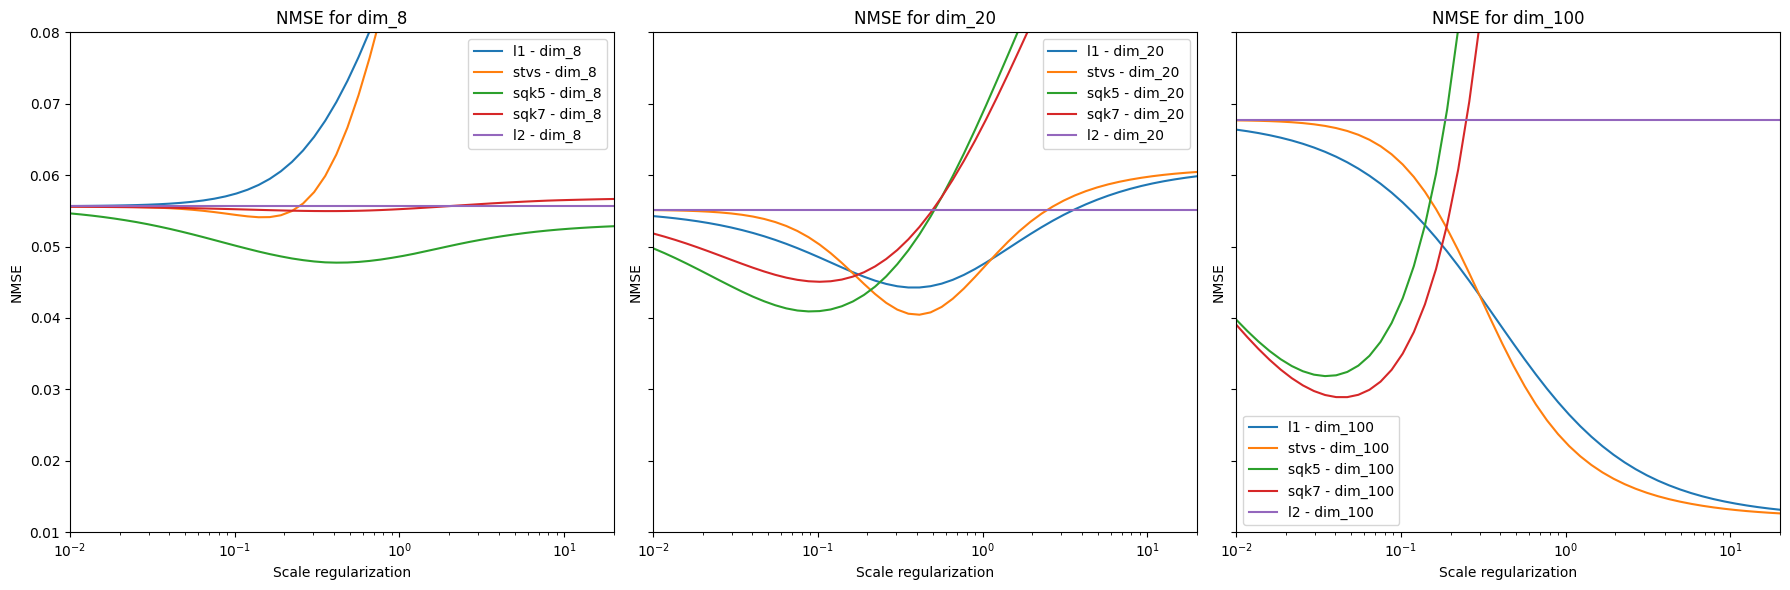

In [25]:
dimensions = ['dim_8', 'dim_20', 'dim_100']  
cost_list = ['l1', 'stvs', 'sqk5', 'sqk7', 'l2']  

fig, axes = plt.subplots(nrows=1, ncols=len(dimensions), figsize=(18, 6), sharey=True)

for index, dimension in enumerate(dimensions):
    ax = axes[index]
    for cost in cost_list:
        if dimension in results_dict[cost]:

            reg_losses = []
            nmses = []
            for scale_reg, data in results_dict[cost][dimension].items():
                reg_losses.append(float(scale_reg))
                nmses.append(data['NMSE'])

            sorted_indices = np.argsort(reg_losses)
            reg_losses = np.array(reg_losses)[sorted_indices]
            nmses = np.array(nmses)[sorted_indices]
            
            ax.plot(reg_losses, nmses, label=f'{cost} - {dimension}')

    if dimension == 'dim_8': 
        ax.set_title(f'NMSE for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.04, 0.07) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('NMSE')
        ax.legend()

    if dimension == 'dim_20': 
        ax.set_title(f'NMSE for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.03, 0.07) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('NMSE')
        ax.legend()

    if dimension == 'dim_100': 
        ax.set_title(f'NMSE for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.01, 0.08) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('NMSE')
        ax.legend()

plt.tight_layout()
plt.show()

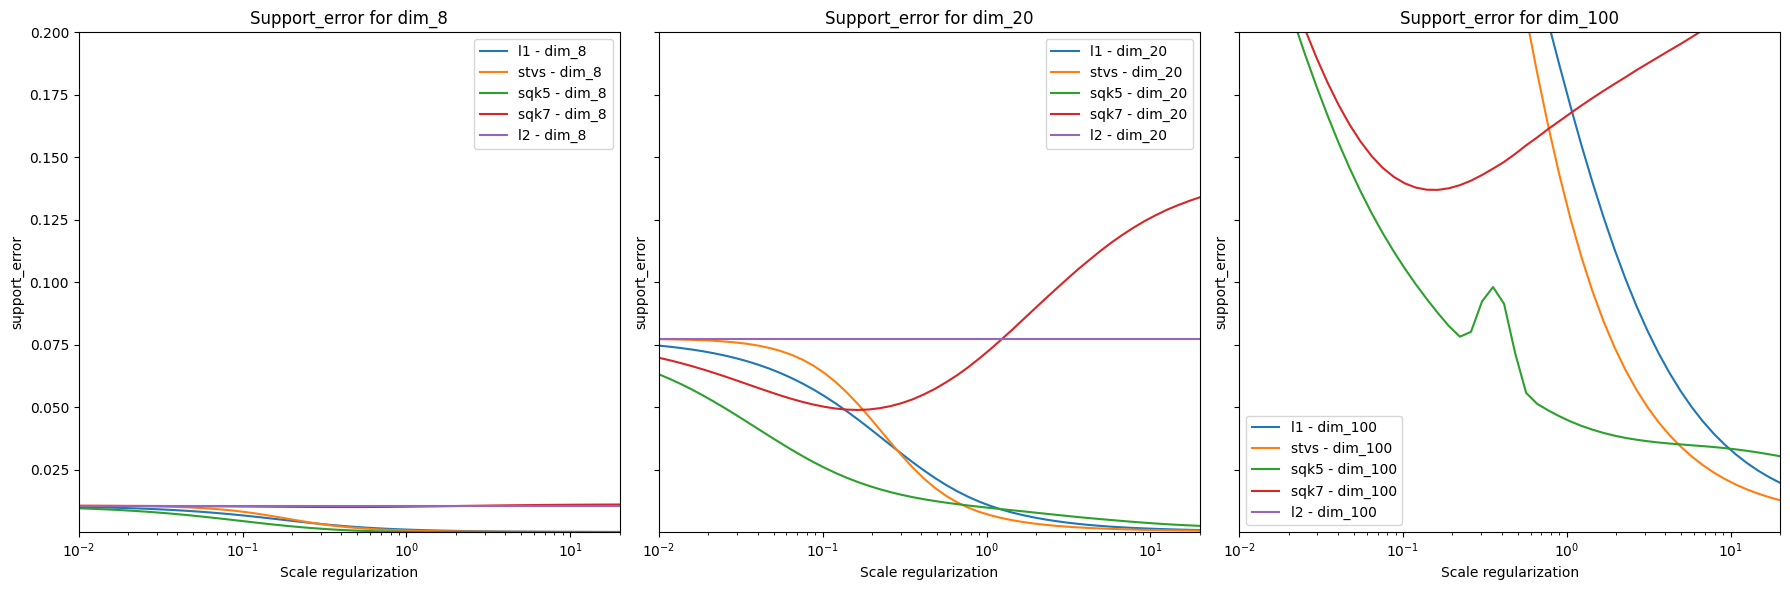

In [33]:
dimensions = ['dim_8', 'dim_20', 'dim_100']  
cost_list = ['l1', 'stvs', 'sqk5', 'sqk7', 'l2'] 

fig, axes = plt.subplots(nrows=1, ncols=len(dimensions), figsize=(18, 6), sharey=True)

for index, dimension in enumerate(dimensions):
    ax = axes[index]
    for cost in cost_list:
        if dimension in results_dict[cost]:

            reg_losses = []
            nmses = []
            for scale_reg, data in results_dict[cost][dimension].items():
                reg_losses.append(float(scale_reg))
                nmses.append(data['support_error'])

            sorted_indices = np.argsort(reg_losses)
            reg_losses = np.array(reg_losses)[sorted_indices]
            nmses = np.array(nmses)[sorted_indices]
            
            ax.plot(reg_losses, nmses, label=f'{cost} - {dimension}')

    if dimension == 'dim_8': 
        ax.set_title(f'Support_error for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.000001, 0.07) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('support_error')
        ax.legend()

    if dimension == 'dim_20': 
        ax.set_title(f'Support_error for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.0001, 0.07) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('support_error')
        ax.legend()

    if dimension == 'dim_100': 
        ax.set_title(f'Support_error for {dimension}')
        ax.set_xscale('log')
        ax.set_ylim(0.000001, 0.2) 
        ax.set_xlim(0.01, 20) 
        ax.set_xlabel('Scale regularization')
        ax.set_ylabel('support_error')
        ax.legend()

plt.tight_layout()
plt.show()

### Results analysis and interpretation

Finally, the results are quite similar to those presented in the research paper. 

When the dimension is small (s close to d), the l2 cost function achieves a good NMSE, and the other approaches generally perform less well (except sqk5). Above all, the other methods are less and less efficient as the value of the regularization scale increases. 
However, as the dimension increases, we find that the other methods outperform the l2 cost function in terms of NMSE. Adding a regularization term improves the entropy map calculation. 

For medium-sized data (d = 20), we find an optimal regularization value of around 0.1 for the sqk cost functions and 5 for the L1 and stvs functions. 
For high-dimensional data (d = 100), the L1 and stvs cost functions seem to perform better as scale regularization increases, while the sqk functions have an optimal regularization value of around 0.05.

The results of this experiment highlight the value of the methods introduced in this paper. 
Indeed, we can see that, when the data shift is really sparse (s << d), adding a regularization term enables a really more efficient calculation of the entropic map.

# Partie 2

## Synthetic experiments: $x$-dependent sparsity pattern

In this experiment, we extend the constant sparsity pattern experiment by allowing the sparsity pattern of the transport map to adapt based on the input vector $x$

We consider two groups of coordinates of $x$ and we decide to transform the group with the larger norm. The method's performance is evaluated as the dimension $d$ increases, with the aim of observing how well it scales and whether it can mitigate the curse of dimensionality.

We first introduce the new theoretical mapping using the T_star_new function

In [6]:
def T_star_new(x, s):
    n1 = jnp.sum(x[:s]**2)
    n2 = jnp.sum(x[s:2*s]**2) 

    if n1 > n2:
        return jnp.concatenate([jnp.exp(x[:s]), x[s:]])
    else:
        return jnp.concatenate([x[:s], jnp.exp(x[s:2*s]), x[2*s:]])

In this study, the aim is to compare the behavior of cost functions as a function of data dimension, by varying dimensions over a wider range (from 0 to 500 in our analysis, due to lack of computing power to go higher). To achieve this, we need to search for an optimal regularization scale for each cost function and dimension. 
Once again, for reasons of computational power, the search for the optimum regularization scale will be carried out using a list of 10 values. We therefore start by implementing a list of 5 cost functions with 10 regularization scales per function, in the same way as in part 1.  

In [27]:
dimensions = [10, 20, 50, 100, 250, 500]
s = 2
n = 1000
scale_reg_list = jnp.logspace(jnp.log10(0.01), jnp.log10(20), num=10)

new_elastic_cost = [costs.ElasticL1(scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
new_elastic_stvs = [costs.ElasticSTVS(scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
new_elastic_sqk5 = [costs.ElasticSqKOverlap(k=5, scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
new_elastic_sqk7 = [costs.ElasticSqKOverlap(k=7, scaling_reg=scale_reg_param) for scale_reg_param in scale_reg_list]
new_l2_cost = [costs.SqEuclidean() for _ in range(10)]

new_cost_list = list(itertools.chain(new_elastic_cost, new_elastic_stvs, new_elastic_sqk5, new_elastic_sqk7, new_l2_cost))

For each dimension and each cost function, we perform an optimal scale search before calculating the entropic map with the corresponding value. The results are again stored in a dictionary to evaluate the behavior of each cost function. 

In [8]:
def results_x_dependant(cost_func) :
    cost_results = {}
    for dim in dimensions :
        print('cost: ', cost_func[0], 'dimension:', dim) 
            
        cost_results[f'dim_{dim}'] = {}
        x = jax.random.uniform(rng, (n, dim))

        T_star = jnp.array([T_star_new(x, s) for x in x])
        x_tilde = jax.random.uniform(rng2, (n, dim))

        y = jnp.array([T_star_new(x, s) for x in x_tilde])

        nmse = 10
        for index in tqdm(range(len(cost_func))):
            T_h = entropic_map(x,y,cost_fn=cost_func[index])(x)
            nmse_1 = nmse_func(T_star, T_h, dim)
            if nmse_1 < nmse : 
                nmse = nmse_1
                reg_scale = index

        T_h = entropic_map(x,y,cost_fn=cost_func[reg_scale])(x)
        best_nmse = nmse_func(T_star, T_h, dim)

        cost_results[f'dim_{dim}']['NMSE'] = best_nmse
    print(cost_results)
    return(cost_results)

new_results_dict = {}
new_results_dict['l1'] = results_x_dependant(new_elastic_cost)
new_results_dict['stvs'] = results_x_dependant(new_elastic_stvs)
new_results_dict['sqk5'] = results_x_dependant(new_elastic_sqk5)
new_results_dict['sqk7'] = results_x_dependant(new_elastic_sqk7)
new_results_dict['l2'] = results_x_dependant(new_l2_cost)

cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 10


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 20


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 50


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 100


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 250


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


cost:  <ott.geometry.costs.ElasticL1 object at 0x15ec4b6d0> dimension: 500


100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


{'dim_10': {'NMSE': Array(0.04683929, dtype=float32)}, 'dim_20': {'NMSE': Array(0.03985571, dtype=float32)}, 'dim_50': {'NMSE': Array(0.04272383, dtype=float32)}, 'dim_100': {'NMSE': Array(0.03639543, dtype=float32)}, 'dim_250': {'NMSE': Array(0.01593735, dtype=float32)}, 'dim_500': {'NMSE': Array(0.00894747, dtype=float32)}}
cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 10


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 20


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 50


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 100


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 250


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


cost:  <ott.geometry.costs.ElasticSTVS object at 0x1641e55d0> dimension: 500


100%|██████████| 10/10 [06:51<00:00, 41.20s/it]


{'dim_10': {'NMSE': Array(0.04534387, dtype=float32)}, 'dim_20': {'NMSE': Array(0.03741458, dtype=float32)}, 'dim_50': {'NMSE': Array(0.04152978, dtype=float32)}, 'dim_100': {'NMSE': Array(0.03587116, dtype=float32)}, 'dim_250': {'NMSE': Array(0.01516877, dtype=float32)}, 'dim_500': {'NMSE': Array(0.00812195, dtype=float32)}}
cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 10


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 20


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 50


100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 100


100%|██████████| 10/10 [05:00<00:00, 30.03s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 250


100%|██████████| 10/10 [10:37<00:00, 63.72s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e5c10> dimension: 500


100%|██████████| 10/10 [34:05<00:00, 204.59s/it]


{'dim_10': {'NMSE': Array(0.05039556, dtype=float32)}, 'dim_20': {'NMSE': Array(0.04296894, dtype=float32)}, 'dim_50': {'NMSE': Array(0.03872006, dtype=float32)}, 'dim_100': {'NMSE': Array(0.03679401, dtype=float32)}, 'dim_250': {'NMSE': Array(0.03569588, dtype=float32)}, 'dim_500': {'NMSE': Array(0.03116566, dtype=float32)}}
cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 10


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 20


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 50


100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 100


100%|██████████| 10/10 [05:06<00:00, 30.63s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 250


100%|██████████| 10/10 [10:46<00:00, 64.67s/it]


cost:  <ott.geometry.costs.ElasticSqKOverlap object at 0x1641e4c10> dimension: 500


100%|██████████| 10/10 [36:47<00:00, 220.75s/it]


{'dim_10': {'NMSE': Array(0.05167801, dtype=float32)}, 'dim_20': {'NMSE': Array(0.0449757, dtype=float32)}, 'dim_50': {'NMSE': Array(0.04080333, dtype=float32)}, 'dim_100': {'NMSE': Array(0.03700217, dtype=float32)}, 'dim_250': {'NMSE': Array(0.0323929, dtype=float32)}, 'dim_500': {'NMSE': Array(0.02701507, dtype=float32)}}
cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 10


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 20


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 50


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 100


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 250


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


cost:  <ott.geometry.costs.SqEuclidean object at 0x1641e4790> dimension: 500


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


{'dim_10': {'NMSE': Array(0.05221681, dtype=float32)}, 'dim_20': {'NMSE': Array(0.04936261, dtype=float32)}, 'dim_50': {'NMSE': Array(0.05873159, dtype=float32)}, 'dim_100': {'NMSE': Array(0.06846273, dtype=float32)}, 'dim_250': {'NMSE': Array(0.0778295, dtype=float32)}, 'dim_500': {'NMSE': Array(0.08108178, dtype=float32)}}


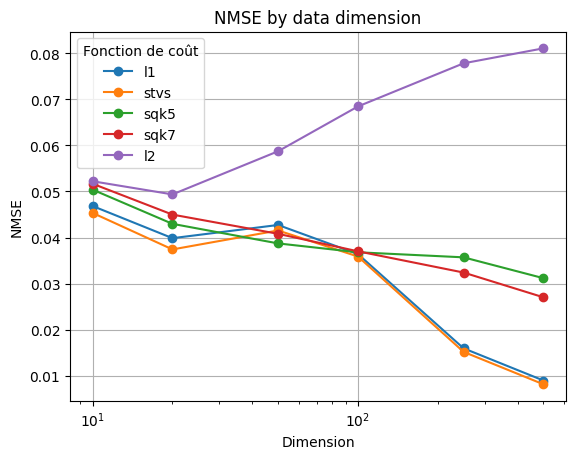

In [13]:
for cost_function, results in new_results_dict.items():
    # Extraire les dimensions et les valeurs NMSE
    dimensions = sorted([int(dim.split('_')[1]) for dim in results])
    nmse_values = [results[f'dim_{dim}']['NMSE'] for dim in dimensions]

    # Tracer les résultats pour chaque fonction de coût
    plt.plot(dimensions, nmse_values, marker='o', label=cost_function)

# Configuration du graphique
plt.xscale('log')
plt.xlabel('Dimension')
plt.ylabel('NMSE')
plt.title('NMSE by data dimension')
plt.legend(title='Fonction de coût')
plt.grid(True)
plt.show()

### Results analysis and interpretation

Here again, the results are broadly similar to those in the paper, although we were unable to carry out exactly the same experiments due to the lack of computing power required. 
Once again, we see that the NMSEs of the entropic maps are very close when d is small (and therefore the displacement is not sparse), but that the methods using cost functions with regularization outperform as the dimension increases (and the displacement becomes more sparse). 
We also see that methods using stvs and L1 cost functions are really very efficient on high-dimensional data (and therefore really sparse displacements). 
These results further highlight the interest of the methods introduced in the paper. 

# Attempted application to color adaptation

We were unable to find a dataset representing an optimal transport problem applied to a sparse displacement. We tried to apply this to biomedical data without success.

We therefore decided to study a simple, low-dimensional optimal transport problem in order to highlight the limitations of this method in this configuration and to illustrate the results obtained in the first experiment with data of dimension 8. 

This section therefore focuses on a color adaptation problem. 

We start by defining three functions to convert images into matrices (to perform the map estimator calculation) and matrices into images (to display the result)

In [45]:
def im2mat(img):
    """Converts and image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

def minmax(img):
    return np.clip(img, 0, 1)

Then we load the images and select samples in order to calculate our map estimator with a smaller computing power.

In [47]:
I1 = plt.imread('/Users/pierrefihey/Desktop/optimal transport/ocean_day.jpg').astype(np.float64) / 256
I2 = plt.imread('/Users/pierrefihey/Desktop/optimal transport/ocean_sunset.jpg').astype(np.float64) / 256

X1 = im2mat(I1)
X2 = im2mat(I2)

nb = 200
rng = np.random.RandomState(42)

idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))
idx3 = rng.randint(X1.shape[0], size=(20,))

Xs = X1[idx1, :]
Xt = X2[idx2, :]
Xnew = X1[idx3, :]

We then define the function that will enable us to graphically display the displacements between the two pixel distributions. Since we want to move from a blue image to a red one, we'll concentrate on the columns representing pixels of these two colors, in order to visualize the shift between these two colors during our analysis.

In [48]:
def plot_map(x, y, x_new=None, z=None, ax=None, title=None):

    red_xs = x[:,0]
    blue_xs = x[:,2] 
    red_flat_xs = red_xs.flatten()
    blue_flat_xs = blue_xs.flatten()
    x = np.vstack((blue_flat_xs, red_flat_xs)).T

    red_xt = y[:,0]  
    blue_xt = y[:,2]  
    red_flat_xt = red_xt.flatten()
    blue_flat_xt = blue_xt.flatten()
    y = np.vstack((blue_flat_xt, red_flat_xt)).T

    red_xnew = x_new[:,0]  
    blue_x_new = x_new[:,2]  
    red_flat_xt = red_xnew.flatten()
    blue_flat_xt = blue_x_new.flatten()
    x_new = np.vstack((blue_flat_xt, red_flat_xt)).T

    red_z= z[:,0]  
    blue_z = z[:,2]  
    red_flat_z = red_z.flatten()
    blue_flat_z = blue_z.flatten()
    z = np.vstack((blue_flat_z, red_flat_z)).T
    
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$", alpha = 0.6)
    ax.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$", alpha = 0.6)
    if z is not None:
        ax.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        ax.scatter(
            *x_new.T, s=150, edgecolors="k", marker="o", label="$x_{new}$", alpha=0.6
        )
        ax.scatter(
            *z.T,
            s=150,
            edgecolors="k",
            marker="X",
            label=r"$T_{x\rightarrow y}(x_{new})$",alpha=0.6
        )
    if title is not None:
        ax.set_title(title)
    ax.legend(fontsize=22)

### With l2 cost function

We first compute the transport map using the l2 cost function, which seemed to perform well in the analysis performed on low-dimensional data, and apply the resulting transport map to the initial image. 

The result is very satisfying, and the graphical representation tells us, unsurprisingly, that coordinate shifts are not sparse.

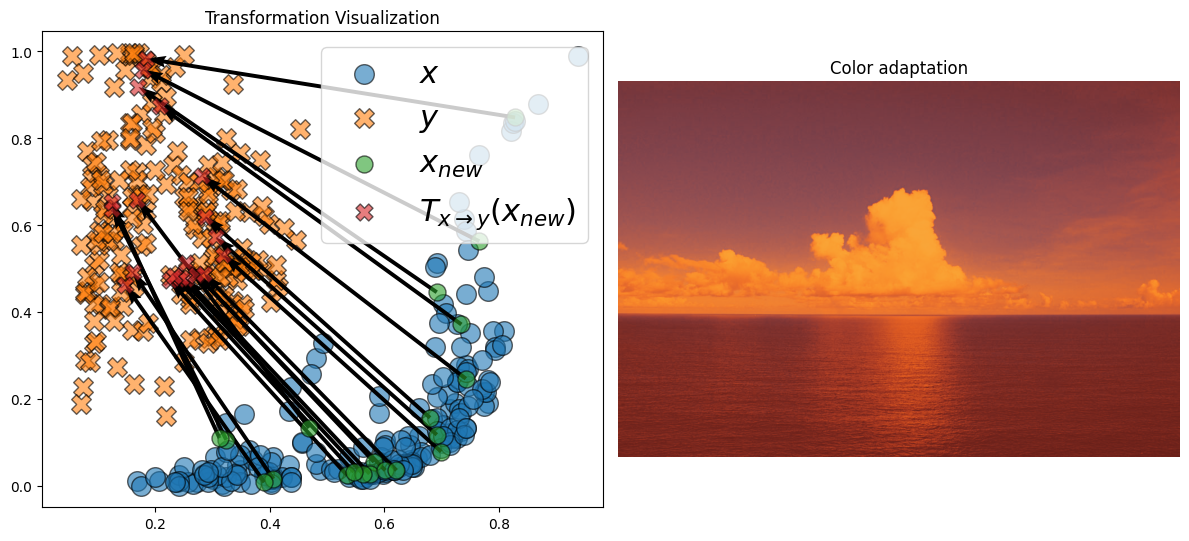

In [42]:
map = entropic_map(Xs, Xt, costs.SqEuclidean())
transport_map = map(X1)

image = minmax(mat2im(transport_map, I1.shape))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_map(Xs, Xt, Xnew, map(Xnew), ax=axs[0])
axs[0].set_title('Transformation Visualization')

# Deuxième graphique
axs[1].imshow(image)
axs[1].axis('off')
axs[1].set_title('Color adaptation')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

### With L1 cost :

We then decided to calculate the transport map using the l1 cost function and varying the regularization scale in order to confirm the results obtained in Experiment 1.

In line with the results of the first experiment, we can see that the images obtained are satisfactory when the scale regularization is very low (the graphical representations show that the displacements are not sparse). 
Above all, the quality of the images deteriorates as the scale regularization increases. We can also see from the graphs that displacements are increasingly sparse as quality deteriorates. 
These results clearly illustrate what was shown in the experiment on synthetic data. 
The cost functions introduced in the research paper are very useful when applied to parsed optimal transport problems, but offer no advantage for low-dimensional data. 


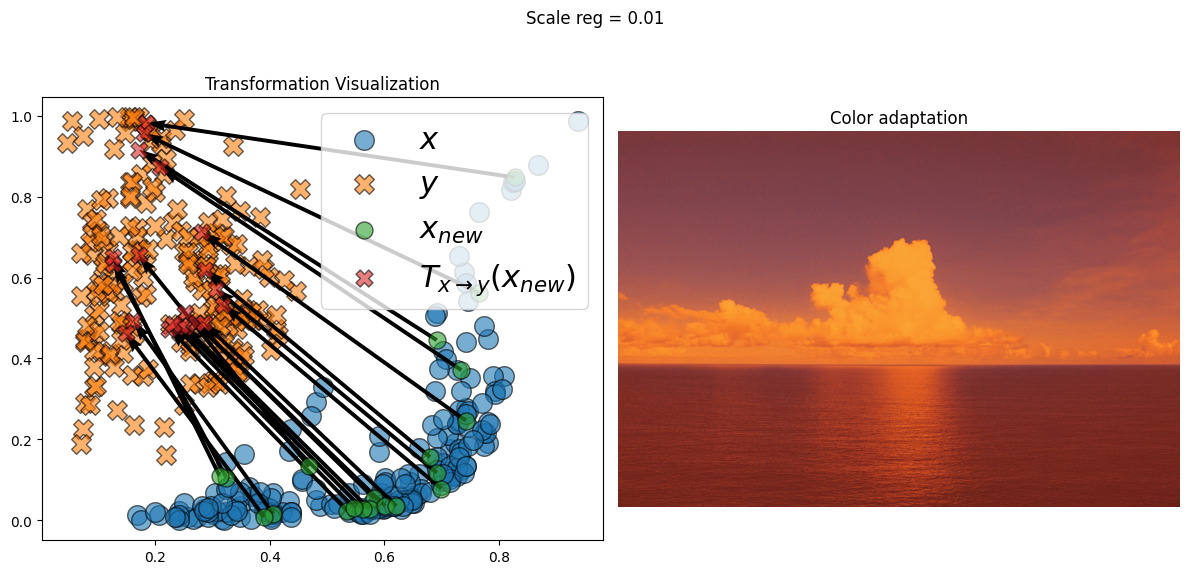

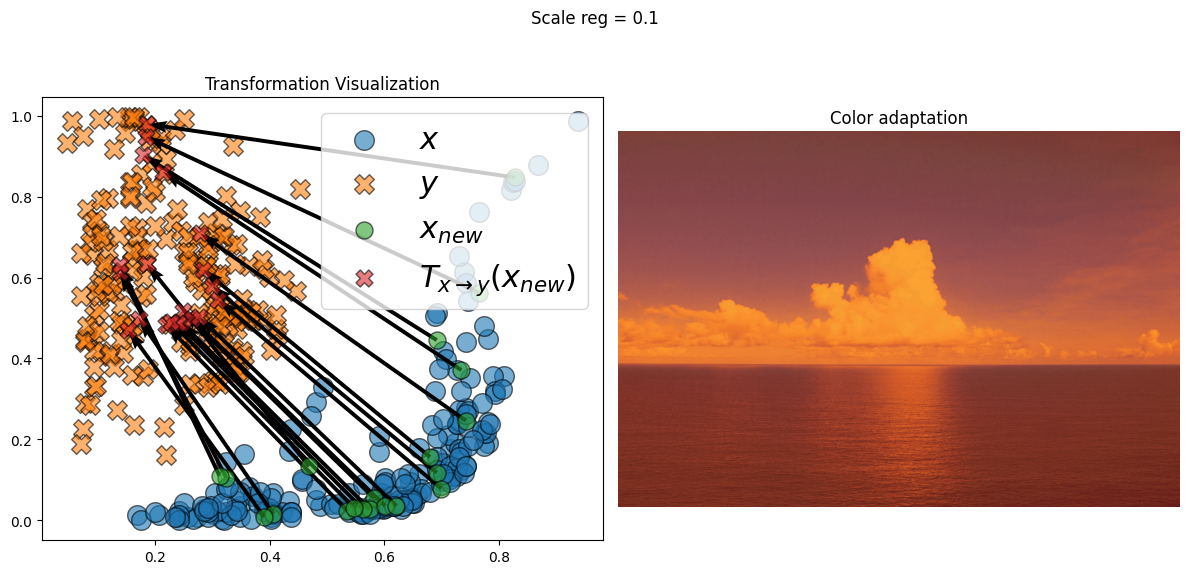

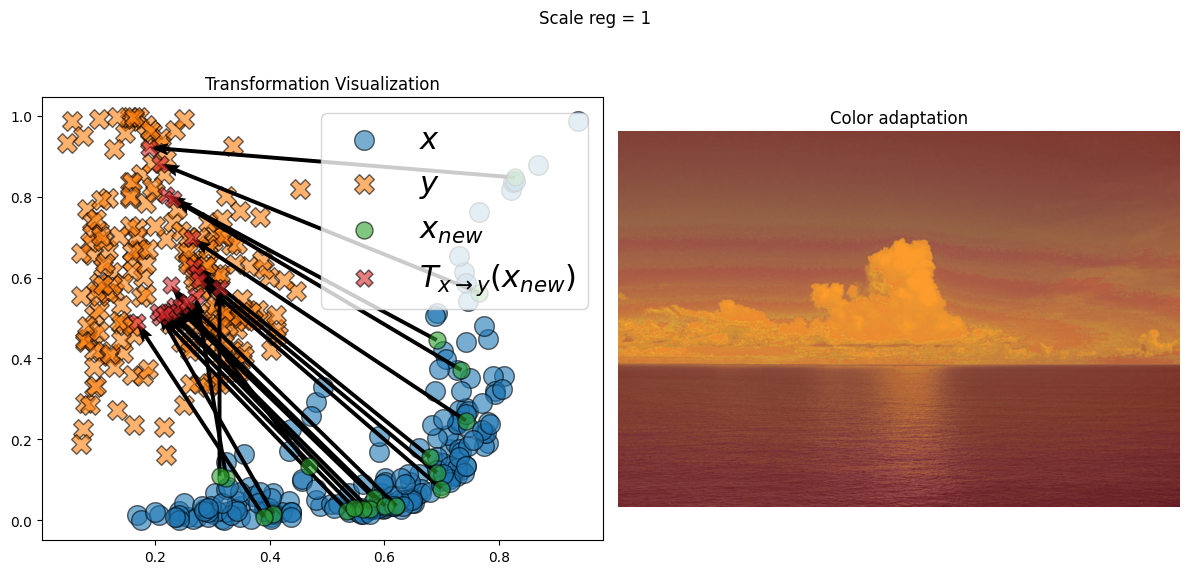

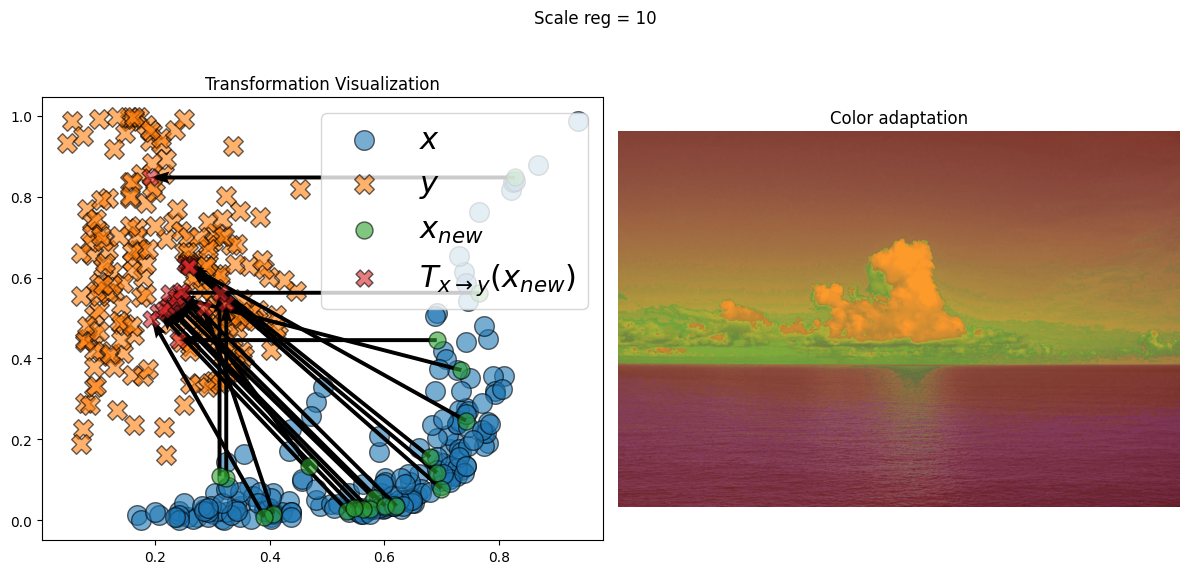

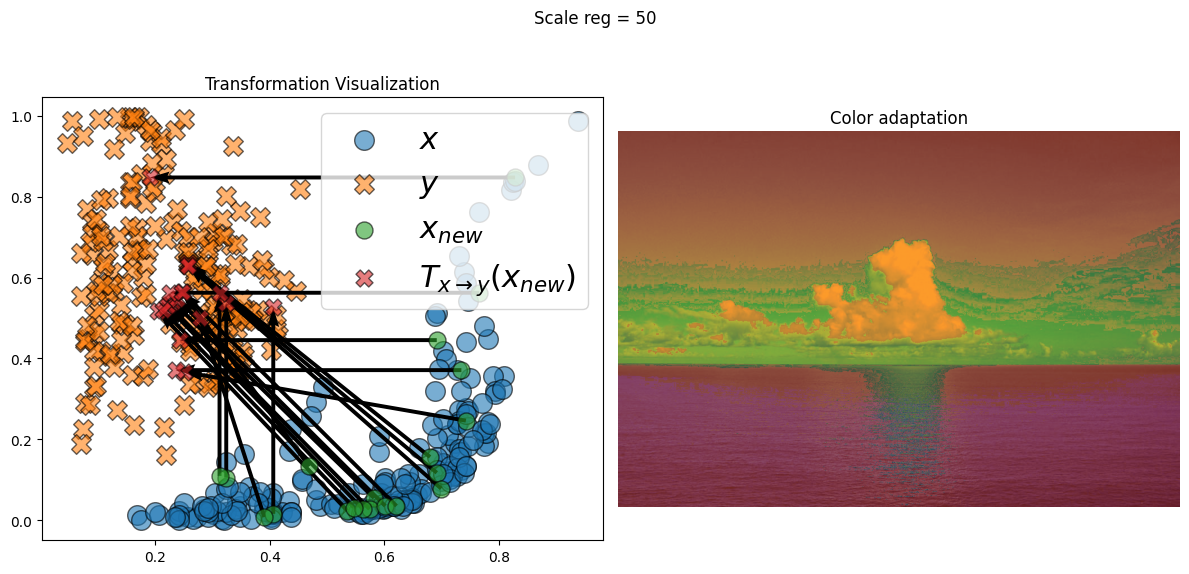

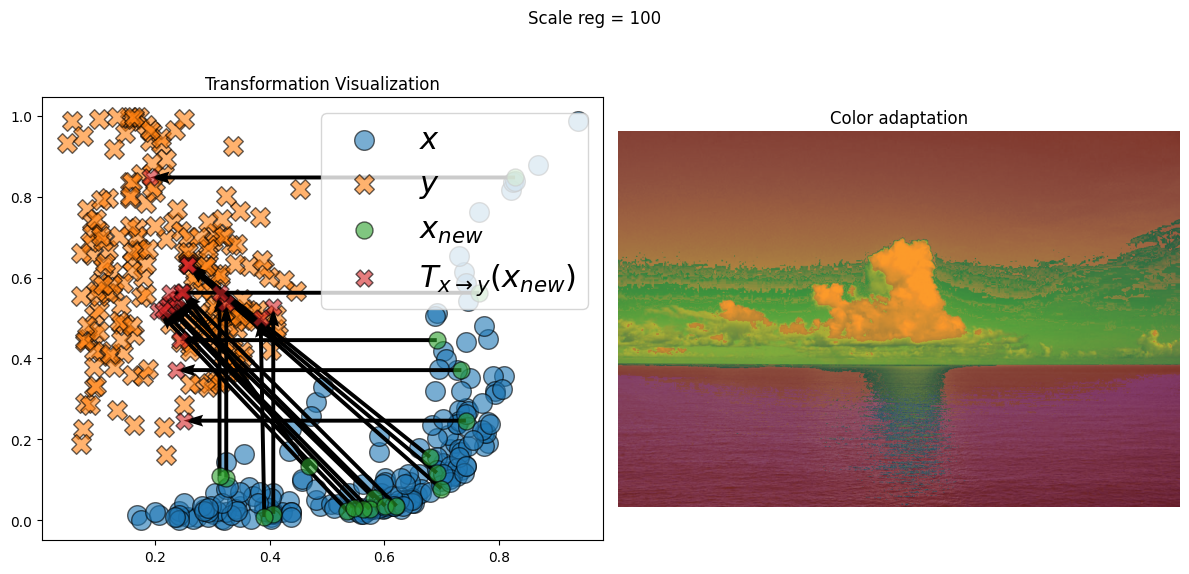

In [37]:
scale_reg_list = [0.01, 0.1, 1, 10, 50, 100]

for reg in scale_reg_list: 

    map = entropic_map(Xs, Xt, costs.ElasticL1(scaling_reg=reg))
    transport_map = map(X1)

    image = minmax(mat2im(transport_map, I1.shape))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_map(Xs, Xt, Xnew, map(Xnew), ax=axs[0])
    axs[0].set_title('Transformation Visualization')

    # Deuxième graphique
    axs[1].imshow(image)
    axs[1].axis('off')
    axs[1].set_title('Color adaptation')

    # Ajouter un titre commun
    fig.suptitle(f'Scale reg = {reg}')

    # Ajuster et afficher
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()